# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import abc
import time
import typing

import tqdm
import torch
import numpy
import wandb
import random
import pandas
import sklearn.metrics
import sklearn.linear_model
import sklearn.preprocessing
import torch.utils.data as torchdata

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_random_seed(RANDOM_STATE)

cuda


In [2]:
wandb.login(anonymous = "allow")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ttpo100ajiex (hse-iad). Use `wandb login --relogin` to force relogin


True

In [3]:
! wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
df = pandas.read_csv('data.txt.zip', header = None)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2006,51.28467,45.88068,22.19582,-5.53319,-3.61835,-16.36914,2.12652,5.18160,-8.66890,...,4.81440,-3.75991,-30.92584,26.33968,-5.03390,21.86037,-142.29410,3.42901,-41.14721,-15.46052
515341,2006,49.87870,37.93125,18.65987,-3.63581,-27.75665,-18.52988,7.76108,3.56109,-2.50351,...,32.38589,-32.75535,-61.05473,56.65182,15.29965,95.88193,-10.63242,12.96552,92.11633,10.88815
515342,2006,45.12852,12.65758,-38.72018,8.80882,-29.29985,-2.28706,-18.40424,-22.28726,-4.52429,...,-18.73598,-71.15954,-123.98443,121.26989,10.89629,34.62409,-248.61020,-6.07171,53.96319,-8.09364
515343,2006,44.16614,32.38368,-3.34971,-2.49165,-19.59278,-18.67098,8.78428,4.02039,-12.01230,...,67.16763,282.77624,-4.63677,144.00125,21.62652,-29.72432,71.47198,20.32240,14.83107,39.74909


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
class BaseModel(abc.ABC):
    def __init__(self):
        self.x_scaler = sklearn.preprocessing.StandardScaler()
        self.y_scaler = sklearn.preprocessing.StandardScaler()

    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        if (y is not None):
            # It is train dataset
            y = y.reshape(-1, 1)
            X = self.x_scaler.fit_transform(X)
            y = self.y_scaler.fit_transform(y)
            return X, y.flatten()
        else:
            # It is test dataset
            return self.x_scaler.transform(X)

    def postprocess(self, y_pred: numpy.ndarray) -> numpy.ndarray:
        y_pred = y_pred.reshape(-1, 1)
        return self.y_scaler.inverse_transform(y_pred).flatten()

    @abc.abstractmethod
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        raise NotImplementedError

    @abc.abstractmethod
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        raise NotImplementedError

In [7]:
def RMSE(y_true: numpy.ndarray, y_pred: numpy.ndarray) -> float:
    assert y_true.shape == y_pred.shape
    return sklearn.metrics.mean_squared_error(y_true, y_pred, squared = False)

def calc_metrics(model: BaseModel) -> dict:
    return {
        'Train RMSE': RMSE(y_train, model.predict(X_train)),
        'Test RMSE': RMSE(y_test, model.predict(X_test)),
    }

In [8]:
class RidgeRegresseion(BaseModel):
    def __init__(self, alpha = 1.0):
        super().__init__()
        self.model = sklearn.linear_model.Ridge(alpha)

    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        X, y = self.preprocess(X, y)
        self.model = self.model.fit(X, y)
        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
      X = self.preprocess(X)
      y = self.model.predict(X)
      return self.postprocess(y)

set_random_seed(42)
calc_metrics(RidgeRegresseion().fit(X_train, y_train))

{'Train RMSE': 9.552822967970322, 'Test RMSE': 9.510160820470436}

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [9]:
class ConstantRegresseion(BaseModel):
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        self.prediction = numpy.mean(y)
        return self

    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
      return numpy.full(X.shape[0], self.prediction)

set_random_seed(42)
calc_metrics(ConstantRegresseion().fit(X_train, y_train))

{'Train RMSE': 10.939755150678016, 'Test RMSE': 10.85246390513634}

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [10]:
class TorchBaseModel(BaseModel):
    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        if y is None:
            X = super().preprocess(X, y)
            return torch.tensor(X, dtype = torch.float32)
        else:
            X, y = super().preprocess(X, y)
            X = torch.tensor(X, dtype = torch.float32)
            y = torch.tensor(y, dtype = torch.float32)
            return X, y

    def postprocess(self, y_pred: torch.Tensor) -> numpy.ndarray:
        return super().postprocess(y_pred.cpu().detach().numpy())

In [11]:
class TorchModel(TorchBaseModel):
    def __init__(
            self,
            name: str,
            batch_size: int,
            device: torch.device,
            model: torch.nn.Module,
            metrics: typing.Callable[[BaseModel], dict]
        ):
        super().__init__()
        self.name = name
        self.history = []
        self.device = device
        self.metrics = metrics
        self.batch_size = batch_size
        self.model = model.to(self.device)

    @abc.abstractmethod
    def train(self, X: torch.Tensor, y: torch.Tensor) -> float:
        raise NotImplementedError
    
    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        for X, y in loader:
            loss = self.train(X, y)
        return loss
        
    def fit(self, X: numpy.ndarray, y: numpy.ndarray, n_epochs: int = 1):
        X, y = self.preprocess(X, y)
        dataset = torchdata.StackDataset(X.to(self.device), y.to(self.device))
        loader = torchdata.DataLoader(dataset, batch_size = self.batch_size, shuffle = True)
        
        wandb.init(project = "DL-HW-1", name = self.name, anonymous = "allow")
        wandb.watch(self.model, log = "all")

        for epoch in tqdm.trange(n_epochs):
            self.model.train()
            train_start = time.perf_counter()
            loss = self.train_epoch(loader)
            train_time = time.perf_counter() - train_start
            metrics = { 'Loss': loss, 'Train time': train_time }

            self.model.eval()
            val_start = time.perf_counter()
            with torch.no_grad():
                metrics.update(self.metrics(self))
            val_time = time.perf_counter() - val_start
            metrics['Validation time'] = val_time
            
            wandb.log(metrics)
            self.history.append(metrics)

        wandb.finish()
        return self
    
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        self.model.eval()
        with torch.no_grad():
            X = self.preprocess(X)
            y = self.model(X.to(self.device))
            return self.postprocess(y)

In [12]:
class MyTorchRegression(TorchModel):
    def __init__(self, learning_rate: float, **kwargs):
        super().__init__("MyTorchRegression", model = torch.nn.Linear(X.shape[1], 1), batch_size = 512, **kwargs)
        self.learning_rate = learning_rate

    def train(self, X: torch.Tensor, y: torch.Tensor) -> float:
        self.model.zero_grad()
        y_pred = self.model(X).squeeze(1)
        loss = torch.mean(torch.square(y_pred - y))
        loss.backward()
        with torch.no_grad():
            self.model.weight -= self.learning_rate * self.model.weight.grad
            self.model.bias -= self.learning_rate * self.model.bias.grad
        return loss.item()
    
set_random_seed(42)
calc_metrics(MyTorchRegression(1e-3, device = device, metrics = calc_metrics).fit(X_train, y_train, 10))

100%|██████████| 10/10 [00:33<00:00,  3.37s/it]


Loss,▆▂▄▅▁▁▁▃▅█
Test RMSE,█▄▂▂▁▁▁▁▁▁
Train RMSE,█▄▂▂▁▁▁▁▁▁
Train time,█▃▂▁▃▃▁▂▄▃
Validation time,█▂▄▄▅▄▃▅▂▁
Loss,1.00704
Test RMSE,9.5178
Train RMSE,9.55616
Train time,3.10745
Validation time,0.20466


{'Train RMSE': 9.556157557269005, 'Test RMSE': 9.517800497093987}

![Alternative Text][1697132425984]

[1697132425984]: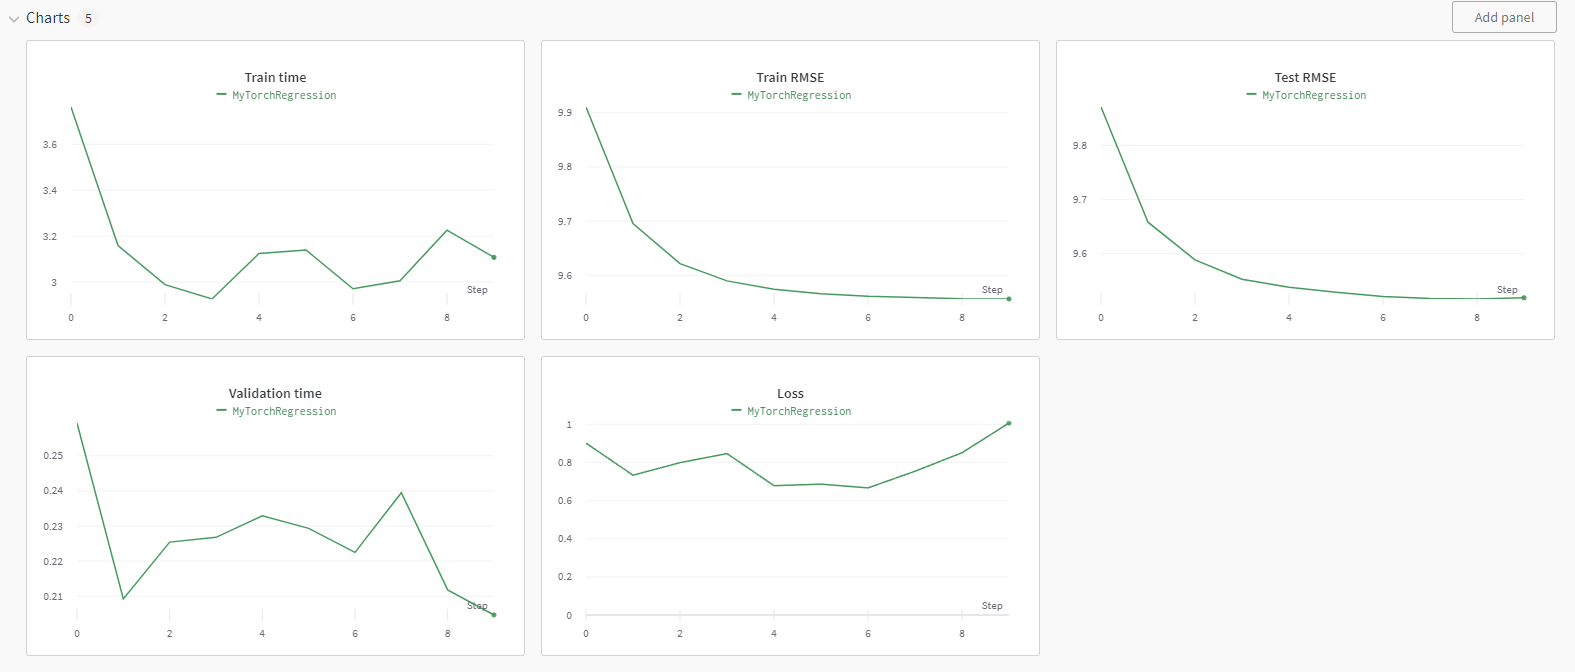

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [13]:
class BestLinreg(TorchBaseModel):
    def preprocess(self, X: numpy.ndarray, y: typing.Optional[numpy.ndarray] = None):
        const_feature = torch.full((X.shape[0], 1), 1)
        if y is None:
            X = super().preprocess(X, y)
            return torch.cat([ X, const_feature ], dim = 1)
        else:
            X, y = super().preprocess(X, y)
            return torch.cat([ X, const_feature ], dim = 1), y
    
    def fit(self, X: numpy.ndarray, y: numpy.ndarray):
        X, y = self.preprocess(X, y)
        X_T = torch.transpose(X, 0, 1)
        self.weights = torch.inverse(X_T @ X) @ X_T @ y # Mathematically best weights
        return self
    
    def predict(self, X: numpy.ndarray) -> numpy.ndarray:
        X = self.preprocess(X)
        return self.postprocess(X @ self.weights)
    
set_random_seed(42)
calc_metrics(BestLinreg().fit(X_train, y_train))

{'Train RMSE': 9.552822900253997, 'Test RMSE': 9.51016049610453}

Математически лучшая модель линейной регрессии показывает недостаточное качество. Следовательно, необходимо рассматривать сети, состоящие из нескольких полносвязных слоёв.

In [14]:
class Model(TorchModel):
    def __init__(
            self,
            optimizer: torch.optim.Optimizer,
            scheduler: typing.Optional[torch.optim.lr_scheduler.LRScheduler] = None,
            **kwargs
        ):
        super().__init__(**kwargs)
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.loss = torch.nn.MSELoss()
    
    def train(self, X: torch.Tensor, y: torch.Tensor) -> float:
        self.optimizer.zero_grad()
        y_pred = self.model(X).squeeze(1)
        loss = self.loss(y_pred, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train_epoch(self, loader: torchdata.DataLoader) -> float:
        for X, y in loader:
            loss = self.train(X, y)
        if self.scheduler is not None:
            self.scheduler.step()
        return loss
    

In [15]:
results = []
def try_model(**kwargs):
    if 'device' not in kwargs:
        kwargs['device'] = device
    if 'metrics' not in kwargs:
        kwargs['metrics'] = calc_metrics
    
    n_epochs = kwargs.get('n_epochs', 50)
    if 'n_epochs' in kwargs:
        del kwargs['n_epochs']
    
    model = Model(**kwargs)
    model.fit(X_train, y_train, n_epochs)
    final_metrics = calc_metrics(model)

    results.append({
        '': '',
        'Name': kwargs['name'],
        'Final test RMSE': final_metrics['Test RMSE'],
        'Final train RMSE': final_metrics['Train RMSE'],
        'Best test RMSE': numpy.min([ metrics['Test RMSE'] for metrics in model.history ]),
        'Best train RMSE': numpy.min([ metrics['Train RMSE'] for metrics in model.history ]),
        "Average train time": numpy.mean([ metrics['Train time'] for metrics in model.history ]),
        "Average validation time": numpy.mean([ metrics['Validation time'] for metrics in model.history ])
    })
    return pandas.DataFrame(results)

### Выберем начальную модель
В качестве оптимизатора воспользуемся `AdamW`, так как этот алгоритм должен сам адаптировать скорость обучения под другие параметры. Таким образом, при экспериментах можно будет не задумываться над необходимостью корректировки параметров оптимизатора. В качестве начального размера пакета возьмём 256: это должно быть не очень мало, но и достаточно много, чтобы модель обучалась не очень долго

In [16]:
set_random_seed(42)
model = torch.nn.Sequential(torch.nn.Linear(90, 45), torch.nn.ReLU(), torch.nn.Linear(45, 1)).to(device)
optimizer = torch.optim.AdamW(model.parameters())
try_model(name = "First model", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:48<00:00,  4.57s/it]


Loss,▆▅▃▄▆▆▅▂▁▇▃▁█▂▂▄█▄▆▂▃▆▂▃▃▂▃▁▄▅▅▁▂▄▃▂▁▂▂▅
Test RMSE,█▆▅▅▄▄▄▃▃▂▃▄▃▂▃▃▂▂▂▂▄▂▂▄▂▁▃▂▁▁▁▂▂▂▄▂▃▂▃▂
Train RMSE,█▆▅▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▃▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▂▁▁▁
Train time,▆█▆▅█▃█▅▆▆▂▅▃▄▄▅▅▂▄▅▇▂▂▂▂▂▆▅▁▂▃▄▄▅▇▃▂▁▆▄
Validation time,▃▅▄▃▃▄▄▃▁▄▃▂▄▃▄▃▄▆▄▁▃█▃▃▃▄▃▄▇▃▆▃▃▄▁▃▃▃▆▅
Loss,0.75439
Test RMSE,8.90894
Train RMSE,8.64916
Train time,4.28927
Validation time,0.30012


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859


![Alternative Text][1697132654731]

[1697132654731]: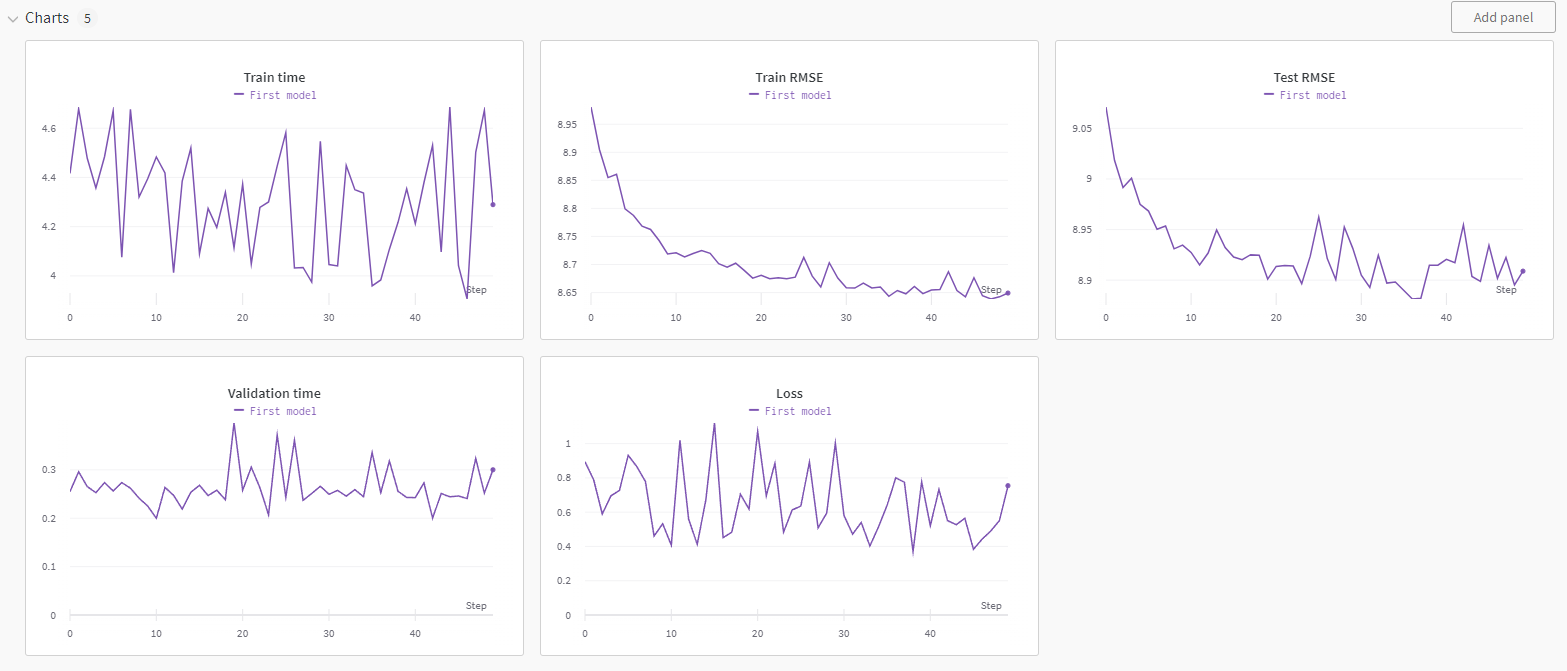

Кажется, длина шага слишком большая. Графики RMSE как на тестовой, так и на тренировочной выборке выглядят не очень плавно, часто вырастают. Попробуем уменьшить длину шага.

In [17]:
set_random_seed(42)
model = torch.nn.Sequential(torch.nn.Linear(90, 45), torch.nn.ReLU(), torch.nn.Linear(45, 1)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "First model - 2", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:55<00:00,  4.70s/it]


Loss,▇▆▃▄▇▆▅▂▁█▃▂█▂▃▄▇▄▆▃▄▆▂▃▃▂▃▁▄▆▅▁▂▅▃▃▁▂▃▅
Test RMSE,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▇▅▃▆▄▁▄▄▂▂▂▃▆▅▆▅▃▁▂▇▇▅▅▅▅▃▆▃▃▅█▆▇▆▄▃▃▅▆▃
Validation time,▃▁▁▂▃▅▁▁▃█▃▃▂▄█▃▂▂█▃▃▃▃▃▃▃▃▄▃▃▃▂▁▃▂▃▆▃▃▂
Loss,0.79886
Test RMSE,8.93422
Train RMSE,8.72842
Train time,4.25093
Validation time,0.24237


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297


![Alternative Text][1697132900219]

[1697132900219]: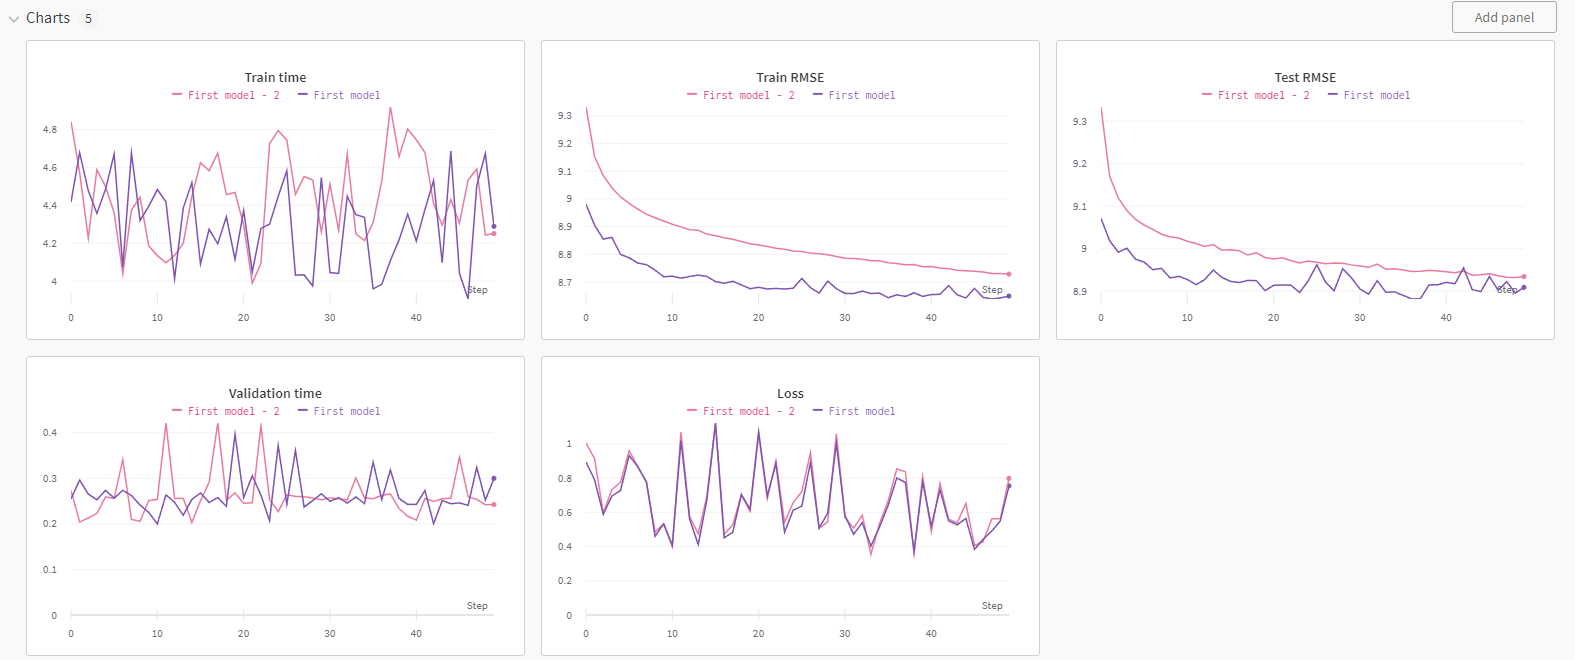

Однозначно стало лучше: модель обучается более плавно. Остановимся на этом.

### Попробуем различное количество слоев
Будем распределять нейроны в скрытых слоях равномерно. Кажется, это должен быть оптимальный вариант.

In [18]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 45),
    torch.nn.ReLU(), torch.nn.Linear(45, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "45 neurons", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:35<00:00,  4.31s/it]


Loss,▇▆▃▄▇▆▅▂▁█▃▂█▂▃▄▇▄▆▃▄▆▂▃▃▂▃▁▄▆▅▁▂▅▃▃▁▂▃▅
Test RMSE,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▆█▅▄▅▅▄▅▄▃▂▂▂▂▁▂▃▁▂▃▁▂▂▂▂▂▂▁▂▂▂▁▂▁▂▂▂▂▃▂
Validation time,▄▁▁▂▃▁▂▁▃▆▆▂▆▆▅▃▇▃▃▃▆▆▅▆▆▆▆▆▆▇▅▆▅▆▆▆▃█▆▆
Loss,0.79886
Test RMSE,8.93422
Train RMSE,8.72842
Train time,3.83504
Validation time,0.31926


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769


In [19]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "60 + 30 neurons", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:40<00:00,  4.41s/it]


Loss,▅▇▅▆▂▃▄▆▅▅█▃▂▃▄▅▄▂▄▃▃▃▄▄▄▅▅▅▃▃▃▄▄▅▁▃▃▂▃▄
Test RMSE,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▅▅▆▄▇▄▅▄▇█▄▇▅▆▅▆▆█▃▆▆▅▂▅▁▇▅▅▁▆▄▂▄▄▅▂▃▁▅▄
Validation time,▆▆▃▆▃▅▆▆▆▁▆▆▆▅▅▆▃▅█▆▆▅▆▅▆▁▆▆▂▆▆▆▆▆▆▅▆▆▆▆
Loss,0.66315
Test RMSE,8.81932
Train RMSE,8.39686
Train time,4.02564
Validation time,0.37932


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231


In [20]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 65),
    torch.nn.ReLU(), torch.nn.Linear(65, 40),
    torch.nn.ReLU(), torch.nn.Linear(40, 20),
    torch.nn.ReLU(), torch.nn.Linear(20, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "65 + 40 + 20 neurons", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:58<00:00,  4.77s/it]


Loss,▃▁▂▄▃▂▂▅▆▂▃▃█▃▄▂▁▃▂▄▁▂▄▃▃▃▁▂▃▂▅▂▂▂▂█▁▄▄▃
Test RMSE,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▁▂▂▂▂▂
Train RMSE,█▆▆▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train time,▃█▅▃▄▄▃▅▃▁▃▄▆▄▅▄▄▄▃▃▂▄▆▂▄▃▄▃▃▅▃▁▂▄▃▂▄▇▇▅
Validation time,█▁▇▅▇█▃▃▃▆▄▃▃▇▇▃▆▆▅▇▅▆▇▇▁▇█▆▇▆▇▃██▇█▁▄▄▃
Loss,0.60192
Test RMSE,8.87277
Train RMSE,8.31584
Train time,4.57663
Validation time,0.2699


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707


In [21]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 72),
    torch.nn.ReLU(), torch.nn.Linear(72, 54),
    torch.nn.ReLU(), torch.nn.Linear(54, 36),
    torch.nn.ReLU(), torch.nn.Linear(36, 18),
    torch.nn.ReLU(), torch.nn.Linear(18, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "72 + 54 + 36 + 18 neurons", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [04:20<00:00,  5.21s/it]


Loss,▄▅█▆▆▄▁▆█▃▅▆▃▆▅▇▃▇▄▅▄▇▃▆▆▅▂▆▂▃▃▆▅▅▇▅▃▃█▆
Test RMSE,█▅▄▄▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▂▂▂▁▂▂▂▂▂▂▃▂▂▃▃▃▃▃▃▃▃
Train RMSE,█▇▆▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
Train time,▄▄▃▆▂▄▃▅▄▂▂▃▃▁▃▂▃▂▃▃▄▂▂▁▃▄▅▃▄▆▇█▅▆▅▅▆█▄▆
Validation time,█▆▄▅▆▃▃▅▅▃▇▃▄▆▅▃▃▇▇▆▅▆▃▃▃▁▁▆▄▃▂▁▄▄▄▂▅▃▄▄
Loss,0.60718
Test RMSE,8.88266
Train RMSE,8.21374
Train time,5.41078
Validation time,0.32153


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942


![Alternative Text][1697133867763]

[1697133867763]: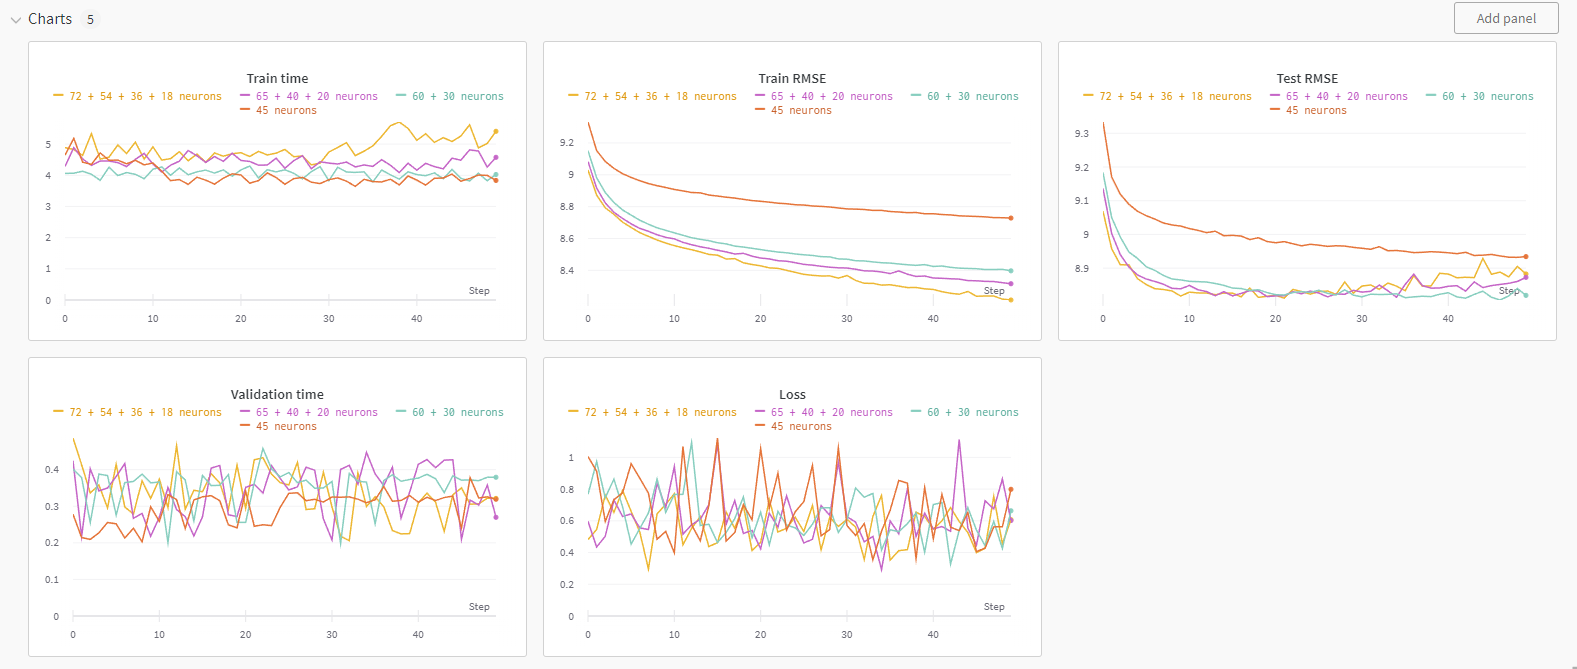

Модель, имеющая один скрытый слой, явно недообучилась, а модели с 3 и 4 слоями - переобучились: значение метрики на тестовой выборке убывало лишь на первых эпохах, после чего возрастало.

### Попробуем различный размер пакета

In [22]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "32 Batch", model = model, optimizer = optimizer, batch_size = 32)

100%|██████████| 50/50 [16:36<00:00, 19.93s/it]


Loss,▁▁▂▂▁▁▂▂▂▆▁▁▁▂▂▅▃▁▂▁▁▃▄▃▁█▁▃▁▄▁▁▁▂▂▃▂▁▂▁
Test RMSE,█▅▄▃▂▂▂▂▂▁▂▂▂▂▂▁▁▁▂▁▃▁▂▂▂▂▂▃▂▂▂▂▃▂▂▃▂▂▂▂
Train RMSE,█▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▆▆▅▆▅█▂▄▇▆▄▅▄▄▆▄▃█▅▅▄▄▇▄▅▃▄▂▄▆▅▄▃▃▂▄▃▃▄▁
Validation time,▂▃██▃▂▂▃▃▃▃▂▂▂▃▂▃▂▃▂▂▄▂▃▁▂▁▂▂▁▂▂▁▂▁▂▅▂▁▂
Loss,0.08523
Test RMSE,8.82142
Train RMSE,8.30162
Train time,17.68814
Validation time,0.20874


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120


![Alternative Text][1697134876538]

[1697134876538]: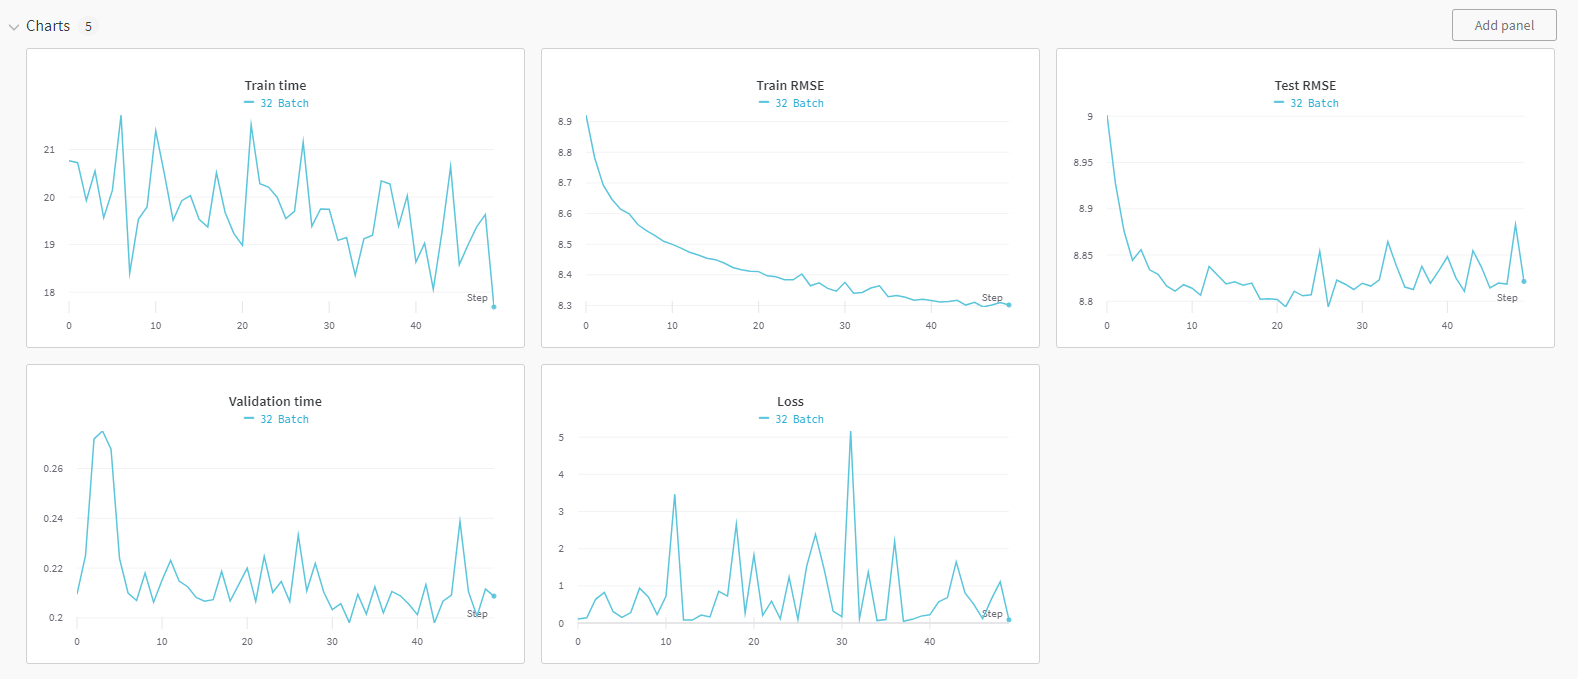

Размер шага явно слишком большой. Получается, при уменьшении размера пакета, длину шага также нужно уменьшать.

In [23]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 2e-5)
try_model(name = "32 Batch - smaller lr", model = model, optimizer = optimizer, batch_size = 32)

100%|██████████| 50/50 [16:28<00:00, 19.77s/it]


Loss,▁▁▂▂▁▁▂▂▂▅▁▁▁▂▃▄▃▁▂▁▁▃▃▃▁█▁▃▁▄▁▁▁▁▂▂▁▁▂▁
Test RMSE,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▄▆▄▄▇▂▁▁▂▁▂▆▂▁▅▄▃▂▂▂▃▄██▇▆▅▇▂▆▄▅▄▆▄▆█▃▄▂
Validation time,▃▃▃▃▁▂▁▂▁▃▄▃▃▂▂▄▂▂▃▂▃▂▄▄▄▂▃▂▂▅▂▂▄▂█▃▆▃▅▄
Loss,0.17482
Test RMSE,8.80918
Train RMSE,8.48055
Train time,18.51868
Validation time,0.21567


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987


In [24]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 4e-5)
try_model(name = "64 Batch", model = model, optimizer = optimizer, batch_size = 64)

100%|██████████| 50/50 [08:49<00:00, 10.58s/it]


Loss,▇▄▄▅▄▄▅▆▅▇▇▃▂▂▃▃▅▃▅▃▁▃▃▂▂▆▄▆▂▃▄▄█▅▂▄▂▃▄▃
Test RMSE,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▆▅▃█▂▁▃▅▃▄▃▄▃▅▂▇▃▂▂▄▄▁▅▂▄▂▂▄▅▆▃▄▆▁▅▂▄▃▂▅
Validation time,▃▄▄▃▄▃▄█▄▆▃▄▆▄▃▄▂▇▅▆▃▄▂▃▄▂▂▂▆▃▂▁▂▃▅▂▇▄▃▃
Loss,0.52214
Test RMSE,8.81573
Train RMSE,8.42994
Train time,10.69379
Validation time,0.20335


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005


In [25]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
try_model(name = "128 Batch", model = model, optimizer = optimizer, batch_size = 128)

100%|██████████| 50/50 [05:34<00:00,  6.70s/it]


Loss,▅▇▅▆▂▃▄▆▅▅█▃▂▃▄▅▄▂▄▃▃▃▄▄▄▅▅▅▃▃▄▄▄▅▁▃▃▂▃▄
Test RMSE,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▃▅▆▃▄▃▇▂▃▄▂▃▃▂▄▅▂▃▃▁▁▄▄▃█▅▃▃▃▃▆▅▆▅▄▅▄▅▅▅
Validation time,▂▄▂▄▅▃▅▁▂▂▃▂▂▄▄▄▁▂▂▄▁▂▁▁▃▅▂▄▂▆▅▄▃▅▆▄▃▅▇█
Loss,0.6495
Test RMSE,8.8184
Train RMSE,8.44422
Train time,6.64891
Validation time,0.22535


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [26]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "256 Batch", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:57<00:00,  4.75s/it]


Loss,▅▇▅▆▂▃▄▆▅▅█▃▂▃▄▅▄▂▄▃▃▃▄▄▄▅▅▅▃▃▃▄▄▅▁▃▃▂▃▄
Test RMSE,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▅█▅▅▆▆▃▄▅▆▄▄▇▃▄▃▃▁▄▃▃▄▄▃▄▂▃▃▄▃▄▂▄▃▄▂▂▁▂▃
Validation time,▄▃▂▄▄▄▄▄▃▃█▂▂▂▂▁▂▁▂▄▂▁▃▁▁▃▁▁▂▄▂▁▁▂▂▂▂▁▂▃
Loss,0.66315
Test RMSE,8.81932
Train RMSE,8.39686
Train time,4.38557
Validation time,0.21119


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [27]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 4e-4)
try_model(name = "512 Batch", model = model, optimizer = optimizer, batch_size = 512)

100%|██████████| 50/50 [03:03<00:00,  3.67s/it]


Loss,▆▆▅▄▆▃▅▆▃▇▆▆▃▅▄▄▄▁▃█▃▄▄▄▂▁▃▆▂▂▃▂▆▅▃▁▃▂▂▃
Test RMSE,█▅▄▃▃▂▂▁▁▁▂▂▂▁▂▁▁▁▂▂▂▂▂▃▂▂▃▃▃▃▃▂▄▃▃▄▃▃▃▃
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train time,█▇▆▆▇▅▄▅▅█▅▃▃▄▂▂▅▃▁▆▄▅▃▇▇▃▄▅▇▃▅▆▆▆▆▅▂▅▄▆
Validation time,▄▅▃▂▃▃▂▂▂▃▄▅▃▁▃▂▁▁▂▂▃▃▃▄▃▃▆█▃▃▅▃▄▂▅▃▂▂▁▂
Loss,0.58745
Test RMSE,8.85768
Train RMSE,8.27124
Train time,3.5524
Validation time,0.20735


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [28]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 8e-4)
try_model(name = "1024 Batch", model = model, optimizer = optimizer, batch_size = 1024)

100%|██████████| 50/50 [02:42<00:00,  3.26s/it]


Loss,▇▆▆▅▅█▅▇▆█▆▆▅▅▅▅▅▅▁▇▅▆▅▃▂▃▄▆▃▄▃▂▇█▂▂▄▅▂▃
Test RMSE,█▅▄▂▂▂▁▁▂▁▂▂▂▁▂▂▁▂▂▂▃▃▂▄▃▃▃▄▃▃▄▃▄▃▂▅▃▃▃▃
Train RMSE,█▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train time,▃▄▃▃▃▂▃▃▃▃▃▃▂▂▂▃▂▃▂▁▂▂▁▂█▂▃▃▂▃▂▂▂▁▂▂▁▂▁▁
Validation time,▄▃▂▅▄▂▃█▂▃▂▄▂▂▃▄▂▃▁▁▃▁▂▁▄▃▄▃▂▃▄▂▂▂▃▂▂▂▄▂
Loss,0.53893
Test RMSE,8.8622
Train RMSE,8.23851
Train time,2.83679
Validation time,0.20038


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697137351387]

[1697137351387]: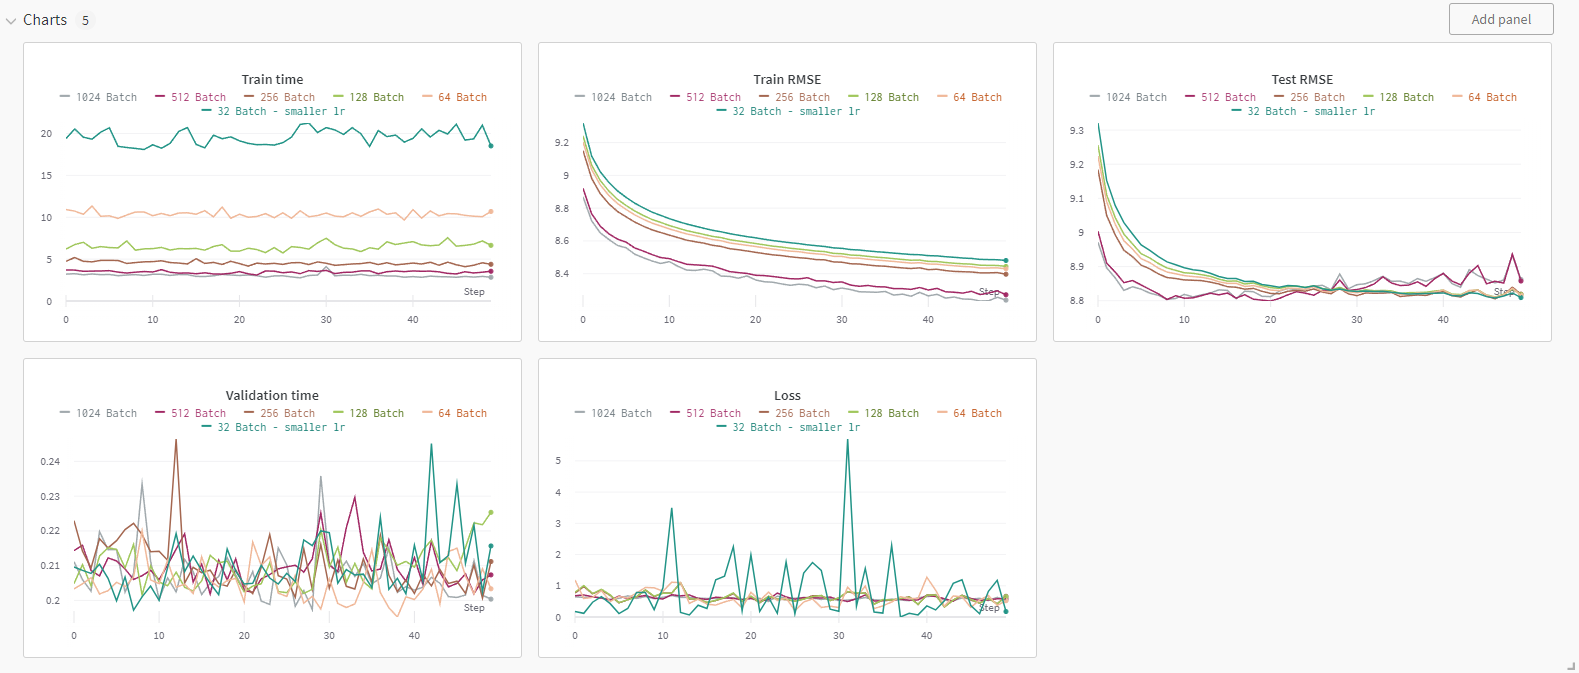

Можно заметить, что большой размер пакета (512, 1024) приводит к переобучению, но в целом размер пакета не оказывает значительного влияния на качество модели при соответствующей корректировке размера шага. Тем не менее обучение на пакетах маленького размера происходит заметно дольше, поэтому для последующих экспериментов продолжим использовать размер пакета 256.

### Попробуем различные оптимизаторы

In [29]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
try_model(name = "SGD", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:28<00:00,  4.17s/it]


Loss,▇█▅▆▂▃▄▆▅▅▇▃▂▃▄▅▅▃▃▃▃▃▃▄▃▄▅▄▃▃▃▄▄▄▁▃▄▂▃▃
Test RMSE,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▃█▇▄▂▇▇▆▃▄▃▃▃▄▄█▅▄▃▂▃▄▃▃▃▃▂▃▃▁▂▃▂▂▁▄▁▂▃▂
Validation time,▄▅▆▆▂▆▄▅▃▃▂▅▂▃▆▇▄▄▂▃▁▁▃▄▁▁▂█▁▁▂▂▂▄▂▁▁▂▂▂
Loss,0.66682
Test RMSE,8.90611
Train RMSE,8.77263
Train time,3.76534
Validation time,0.20294


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [30]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-4, momentum = 0.9)
try_model(name = "SGD with momentum", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:31<00:00,  4.22s/it]


Loss,▇█▅▆▂▃▄▆▅▅▇▃▂▃▄▅▅▃▃▃▃▃▃▄▃▄▅▄▃▃▃▄▄▄▁▃▄▂▃▃
Test RMSE,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▃▆▄▁▃▃▃▁▇▇▃▃▂▂▂▆▃▂▃▆▁▄▃▂█▅▅▆▇▃▄▄▇▅▅▅▅▄▆▃
Validation time,▆▅▄▂▅▂▄▆█▂▂▂▃▂▅▄▂▂▆▆▂▁▃▅▃▂▄█▄▄▂▂▇▆▃▃▄█▇▅
Loss,0.66662
Test RMSE,8.90631
Train RMSE,8.77265
Train time,3.9299
Validation time,0.20896


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [31]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3, weight_decay = 0.01)
try_model(name = "SGD with weight decay", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:29<00:00,  4.18s/it]


Loss,▇█▅▆▂▃▄▆▅▅▇▃▂▃▄▅▅▃▃▃▃▃▃▄▃▄▅▄▃▃▃▄▄▄▁▃▄▂▃▃
Test RMSE,█▆▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train time,▇▆▂▄▆▃▅▄▄▃▅▄▃▆█▄▅▄▃▂▄▂▂▃▄▂▁▆▂▂▄▄▂▃▃▁▃▄▂▃
Validation time,▅▂▂█▁▃▃▂▂▄▅▃▃▅▂▃▁▂▁▂▃▃▂▂▂▂▂▄▅▄▃▂▂▂▂▂▁▁▁▃
Loss,0.66509
Test RMSE,8.8897
Train RMSE,8.78681
Train time,3.93109
Validation time,0.20532


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [32]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60),
    torch.nn.ReLU(), torch.nn.Linear(60, 30),
    torch.nn.ReLU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "AdamW", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [03:39<00:00,  4.40s/it]


Loss,▅▇▅▆▂▃▄▆▅▅█▃▂▃▄▅▄▂▄▃▃▃▄▄▄▅▅▅▃▃▃▄▄▅▁▃▃▂▃▄
Test RMSE,█▆▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▆▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
Train time,█▅▃▅▃▁▄▅▃▃▃▅▆▄▄▃▅▃▃▅▂▃▅▃▂▇▃▃▅▄▃▃▄▃▃▃▃▂▅▃
Validation time,▃▁▄▅▂▃▂▂▁▅▄▄█▅▆▅▃▅▅▃▆▆▄▂▃▂▃▃▂▂▂▂▆▂▃▃▂▃▃▃
Loss,0.66315
Test RMSE,8.81932
Train RMSE,8.39686
Train time,4.13397
Validation time,0.20324


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697139317858]

[1697139317858]: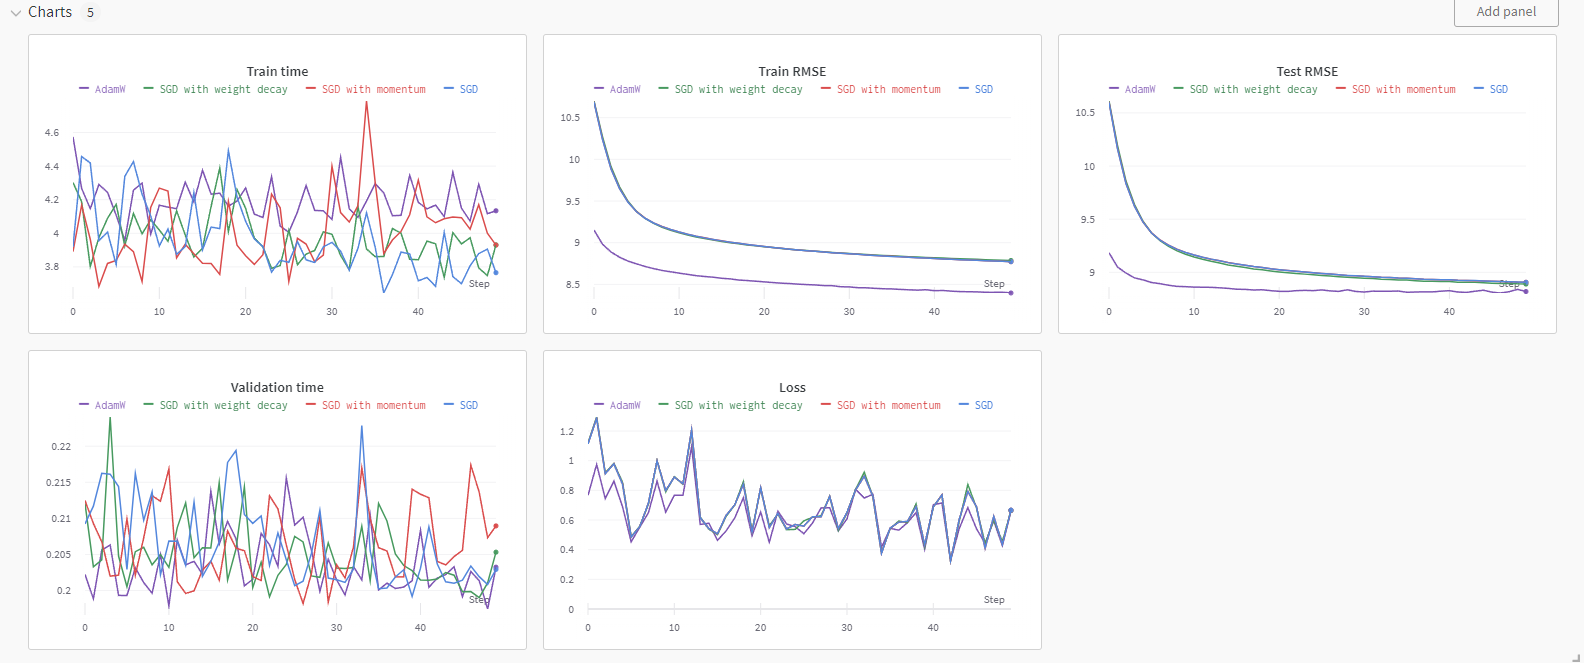

Таким образом, добавление момента и регуляризации в алгоритм не оказывает значительного влияния на качество. Следовательно, сильного переобучения модели не наблюдается. Далее будем использовать `AdamW`: этот алгоритм показал себя гораздо лучше обычного стохастического градиентного спуска.

### Попробуем различные нелинейности
Для ускорения обучения моделей будем обучать всего 10 эпох. Этого должно быть достаточно для выявления общих закономерностей.

In [33]:
def test_activation(name: str, activation_module):
    set_random_seed(42)
    model = torch.nn.Sequential(
        torch.nn.Linear(90, 60),
        activation_module(), torch.nn.Linear(60, 30),
        activation_module(), torch.nn.Linear(30, 1)
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
    return try_model(name = name, model = model, optimizer = optimizer, batch_size = 256, n_epochs = 10)

In [34]:
test_activation("ELU", torch.nn.ELU)

100%|██████████| 10/10 [00:44<00:00,  4.40s/it]


Loss,▅█▅▆▄▁▃▄▆▄
Test RMSE,█▆▅▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,▇█▇▁▇▆▁▄▅▇
Validation time,▅▇▁▃▃▅▇▆▇█
Loss,0.68151
Test RMSE,8.97075
Train RMSE,8.8602
Train time,4.24878
Validation time,0.20558


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [35]:
test_activation("Hardshrink", torch.nn.Hardshrink)

100%|██████████| 10/10 [00:44<00:00,  4.40s/it]


Loss,▅█▄▅▄▁▁▂▆▄
Test RMSE,█▄▃▂▂▁▁▁▁▁
Train RMSE,█▄▃▂▂▂▁▁▁▁
Train time,█▂█▃▁▃▅▄▄▂
Validation time,▅▅▆▆█▆▃▃▁▅
Loss,0.72515
Test RMSE,9.14575
Train RMSE,9.08997
Train time,4.09524
Validation time,0.20271


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [36]:
test_activation("Hardsigmoid", torch.nn.Hardsigmoid)

100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


Loss,▆█▄▅▅▁▁▃▆▄
Test RMSE,█▅▃▂▂▂▁▁▁▁
Train RMSE,█▅▃▂▂▂▂▁▁▁
Train time,▆▆▇▅▆▃▂█▇▁
Validation time,▃▇▅▁▃▄▅█▁▃
Loss,0.76512
Test RMSE,9.19283
Train RMSE,9.18083
Train time,3.98834
Validation time,0.20141


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [37]:
test_activation("Hardtanh", torch.nn.Hardtanh)

100%|██████████| 10/10 [00:44<00:00,  4.40s/it]


Loss,▅█▄▅▄▁▂▃▆▃
Test RMSE,█▆▄▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▂▂▂▁▁
Train time,▄▆▅▄▁█▆▃▄▅
Validation time,█▅▁▁▄▂▂▂▁▁
Loss,0.64706
Test RMSE,8.96877
Train RMSE,8.87716
Train time,4.22505
Validation time,0.19978


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [38]:
test_activation("Hardswish", torch.nn.Hardswish)

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Loss,▅█▅▆▄▁▂▄▇▄
Test RMSE,█▅▄▃▃▂▂▁▁▁
Train RMSE,█▆▄▄▃▂▂▂▁▁
Train time,▄▆▄█▁▅▄▂▆▃
Validation time,▇▄▇▄▂█▂▂▂▁
Loss,0.66663
Test RMSE,8.94645
Train RMSE,8.79805
Train time,4.14169
Validation time,0.20051


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [39]:
test_activation("LeakyReLU", torch.nn.LeakyReLU)

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Loss,▅█▅▆▄▁▂▄▆▄
Test RMSE,█▅▄▃▂▂▂▁▁▁
Train RMSE,█▆▄▃▃▂▂▂▁▁
Train time,█▆▂▃█▅▁▁▆▆
Validation time,█▃▁▁▂█▂▇▂▂
Loss,0.65159
Test RMSE,8.86602
Train RMSE,8.65363
Train time,4.25304
Validation time,0.2008


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [40]:
test_activation("LogSigmoid", torch.nn.LogSigmoid)

100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


Loss,▆█▅▆▅▁▂▄▇▅
Test RMSE,█▅▄▃▃▂▂▂▁▁
Train RMSE,█▆▄▄▃▃▂▂▁▁
Train time,▆▇▅▇█▁▅▄▇▅
Validation time,▆▄▄█▃▄▂▃▇▁
Loss,0.73944
Test RMSE,9.07968
Train RMSE,9.01369
Train time,4.14877
Validation time,0.19636


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [41]:
test_activation("PReLU", torch.nn.PReLU)

100%|██████████| 10/10 [00:45<00:00,  4.56s/it]


Loss,▅█▅▆▄▁▂▃▆▄
Test RMSE,█▆▄▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,█▃▂▅▆▁▅▆▆▆
Validation time,█▅▆▃▃▁▃▄▃▄
Loss,0.65345
Test RMSE,8.86514
Train RMSE,8.68039
Train time,4.39843
Validation time,0.20153


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [42]:
test_activation("RReLU", torch.nn.RReLU)

100%|██████████| 10/10 [00:43<00:00,  4.40s/it]


Loss,▅█▅▆▅▁▃▄▆▄
Test RMSE,█▆▄▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,▅▅▄▁▅▅▇▄▁█
Validation time,█▁▄▅▂▄▂▅▅▄
Loss,0.67947
Test RMSE,8.89269
Train RMSE,8.7463
Train time,4.38088
Validation time,0.20093


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [43]:
test_activation("ReLU", torch.nn.ReLU)

100%|██████████| 10/10 [00:43<00:00,  4.35s/it]


Loss,▅█▅▇▄▁▂▄▆▄
Test RMSE,█▅▄▃▂▂▂▁▁▁
Train RMSE,█▆▄▃▃▂▂▂▁▁
Train time,▄▇▅▆▆▃▅█▁▆
Validation time,█▅▇▆█▂█▁▇▃
Loss,0.65306
Test RMSE,8.86506
Train RMSE,8.65133
Train time,4.17744
Validation time,0.19941


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [44]:
test_activation("ReLU6", torch.nn.ReLU6)

100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Loss,▅█▅▇▄▁▂▄▇▄
Test RMSE,█▅▄▃▂▂▂▁▁▁
Train RMSE,█▆▄▃▃▂▂▂▁▁
Train time,█▄▃▁▄▆▂▂▅▄
Validation time,█▆█▂▅▄▄▅▄▁
Loss,0.64715
Test RMSE,8.86606
Train RMSE,8.65143
Train time,4.21624
Validation time,0.19733


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [45]:
test_activation("RReLU", torch.nn.RReLU)

100%|██████████| 10/10 [00:46<00:00,  4.64s/it]


Loss,▅█▅▆▅▁▃▄▆▄
Test RMSE,█▆▄▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,▅▃▄▄▆█▆▅▁▅
Validation time,▂▄▄▂▆▃█▂▁▆
Loss,0.67947
Test RMSE,8.89269
Train RMSE,8.7463
Train time,4.43774
Validation time,0.21302


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [46]:
test_activation("SELU", torch.nn.SELU)

100%|██████████| 10/10 [00:44<00:00,  4.46s/it]


Loss,▅█▄▆▄▁▂▃▆▃
Test RMSE,█▆▅▄▃▃▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,█▇▅▆▄▃▅▆▁▃
Validation time,██▅▆▆▁▆▂▂▅
Loss,0.6607
Test RMSE,8.9956
Train RMSE,8.90556
Train time,4.08418
Validation time,0.2059


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [47]:
test_activation("CELU", torch.nn.CELU)

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


Loss,▅█▅▆▄▁▃▄▆▄
Test RMSE,█▆▅▃▃▂▂▁▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,█▇▂▁▅▄▄▃▃▅
Validation time,▃▂▄▁▃▂█▅▂▂
Loss,0.68151
Test RMSE,8.97075
Train RMSE,8.8602
Train time,4.18906
Validation time,0.2052


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [48]:
test_activation("GELU", torch.nn.GELU)

100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


Loss,▅█▅▆▄▁▂▃▇▃
Test RMSE,█▅▄▃▂▂▂▁▁▁
Train RMSE,█▅▄▃▃▂▂▂▁▁
Train time,█▂▆▇▄▃▅▁▃▃
Validation time,█▁▄▇▇▄▅▃▃▂
Loss,0.64978
Test RMSE,8.86874
Train RMSE,8.69081
Train time,4.15764
Validation time,0.20295


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [49]:
test_activation("Sigmoid", torch.nn.Sigmoid)

100%|██████████| 10/10 [00:43<00:00,  4.38s/it]


Loss,▆█▄▅▅▁▁▃▆▄
Test RMSE,█▄▃▃▂▂▂▁▁▁
Train RMSE,█▄▃▃▂▂▂▁▁▁
Train time,█▂▂▄▄▄▂▃▅▁
Validation time,▆█▅▁▃▂▄▂▃▁
Loss,0.73985
Test RMSE,9.12845
Train RMSE,9.1089
Train time,3.91712
Validation time,0.20282


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [50]:
test_activation("SiLU", torch.nn.SiLU)

100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


Loss,▅█▅▆▄▁▃▄▇▄
Test RMSE,█▅▄▃▃▂▂▁▁▁
Train RMSE,█▆▄▃▃▂▂▂▁▁
Train time,█▇▅▅▁▆▄▂▃▆
Validation time,█▂▂▁▅▁██▂▃
Loss,0.66123
Test RMSE,8.9119
Train RMSE,8.75422
Train time,4.21498
Validation time,0.20631


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [51]:
test_activation("Mish", torch.nn.Mish)

100%|██████████| 10/10 [00:44<00:00,  4.45s/it]


Loss,▅█▅▆▄▁▃▄▇▄
Test RMSE,█▅▄▃▃▂▂▁▁▁
Train RMSE,█▆▄▃▃▂▂▂▁▁
Train time,█▅▅▅▄▄▅▅▄▁
Validation time,█▃▄▂▇▅▃▄▂▁
Loss,0.66137
Test RMSE,8.90264
Train RMSE,8.74034
Train time,3.9827
Validation time,0.20096


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [52]:
test_activation("Softplus", torch.nn.Softplus)

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Loss,▆█▅▇▅▁▂▄▇▅
Test RMSE,█▅▄▃▃▂▂▂▁▁
Train RMSE,█▆▄▄▃▃▂▂▁▁
Train time,▅█▁▂▃▃▃▁▄▅
Validation time,▇▁▄▆▄▅█▄▂▃
Loss,0.74476
Test RMSE,9.06881
Train RMSE,9.00097
Train time,4.31255
Validation time,0.20467


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [53]:
test_activation("Softshrink", torch.nn.Softshrink)

100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Loss,▆█▄▄▄▁▁▃▆▃
Test RMSE,█▄▃▂▂▁▁▁▁▁
Train RMSE,█▄▃▂▂▂▁▁▁▁
Train time,▅█▅▃▂▁▇▃▁▃
Validation time,▅█▄▆▆▁▇▆▄▄
Loss,0.63846
Test RMSE,9.01007
Train RMSE,8.9065
Train time,4.12746
Validation time,0.20509


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [54]:
test_activation("Softsign", torch.nn.Softsign)

100%|██████████| 10/10 [00:48<00:00,  4.85s/it]


Loss,▅█▄▅▄▁▂▃▆▃
Test RMSE,█▆▅▄▃▃▂▂▁▁
Train RMSE,█▇▅▅▄▃▃▂▁▁
Train time,▄█▁▃▅▂▂▂▃▂
Validation time,▃▅▂▄▅▃▂█▂▁
Loss,0.67464
Test RMSE,8.98071
Train RMSE,8.8931
Train time,4.54543
Validation time,0.20842


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [55]:
test_activation("Tanh", torch.nn.Tanh)

100%|██████████| 10/10 [00:45<00:00,  4.57s/it]


Loss,▅█▄▅▄▁▂▃▆▃
Test RMSE,█▆▅▄▃▂▂▂▁▁
Train RMSE,█▆▅▄▃▃▂▂▁▁
Train time,▅▇▂▁▂▆█▃▅▆
Validation time,▂▁▃▂▁▇█▄▃▃
Loss,0.65036
Test RMSE,8.96835
Train RMSE,8.87924
Train time,4.50398
Validation time,0.20864


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


In [56]:
test_activation("Tanhshrink", torch.nn.Tanhshrink)

100%|██████████| 10/10 [00:48<00:00,  4.87s/it]


Loss,▇█▅▅▄▁▂▃▆▃
Test RMSE,█▅▃▃▂▂▁▁▁▁
Train RMSE,█▅▄▃▂▂▁▁▁▁
Train time,▇▆▄▄█▆▂▁▁▂
Validation time,██▇▃▃▃▁█▂▃
Loss,0.65375
Test RMSE,9.01847
Train RMSE,8.94317
Train time,4.41039
Validation time,0.20999


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697139670154]

[1697139670154]: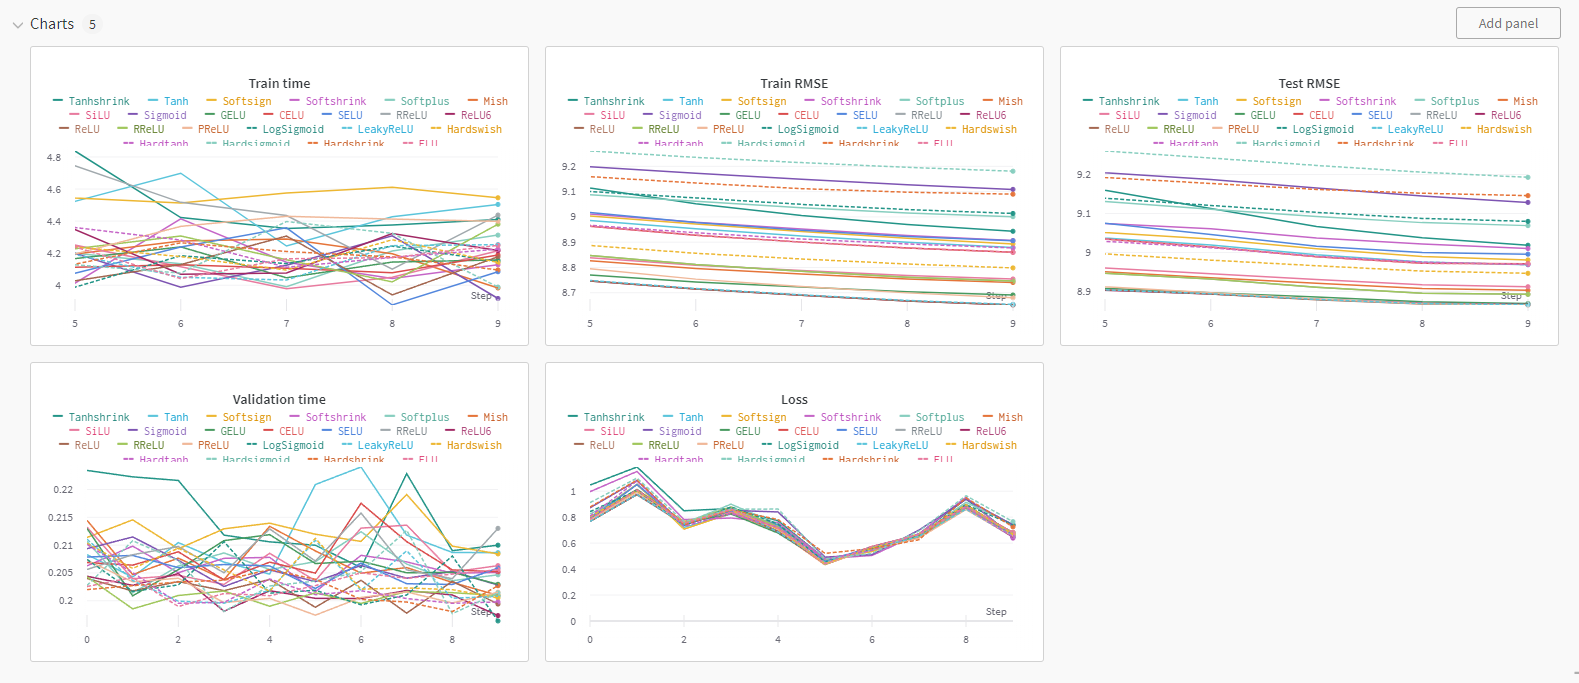

Таким образом, от выбора функции активации качество модели зависит не сильно. Можно лишь выделить, что сигмоида и производные от неё (HardSigmoid, LogSigmoid) показывают себя заметно хуже большинства функций. Плохое качество показали также Shrink и Soft версии функций. Лучшее качество, ожидаемо, показывают GELU, ReLU, LeakyReLU и PReLU. Далее будем использовать GELU: кажется, с этой функцией активации модель обучается немного быстрее без потери качества.

### Нормализация

Говорят, добавление нормализации между слоями должно повышать качество

In [57]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "BatchNorm", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [04:26<00:00,  5.33s/it]


Loss,▅▇▅▅▂▃▄▆▅▅█▃▂▃▄▅▄▂▄▃▃▃▄▄▃▅▅▅▄▃▃▄▄▄▁▃▃▂▃▄
Test RMSE,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train time,▆▃▇▆▄▅▂▁▇▃▅▇▅▆▇▇▃▁▅▁▂▅▅▃▄█▃▄▆▄▃▃▄▅▃▇▇▇▄▇
Validation time,▂▂▆▆▂▂▃▃▃▃▆▅▁▂▃▃▃▁▄▃▂▃▂▅▇▄█▃▄▆▁▂▅▄█▂▅▆▃▄
Loss,0.6549
Test RMSE,8.81325
Train RMSE,8.41645
Train time,5.45248
Validation time,0.21624


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697139781891]

[1697139781891]: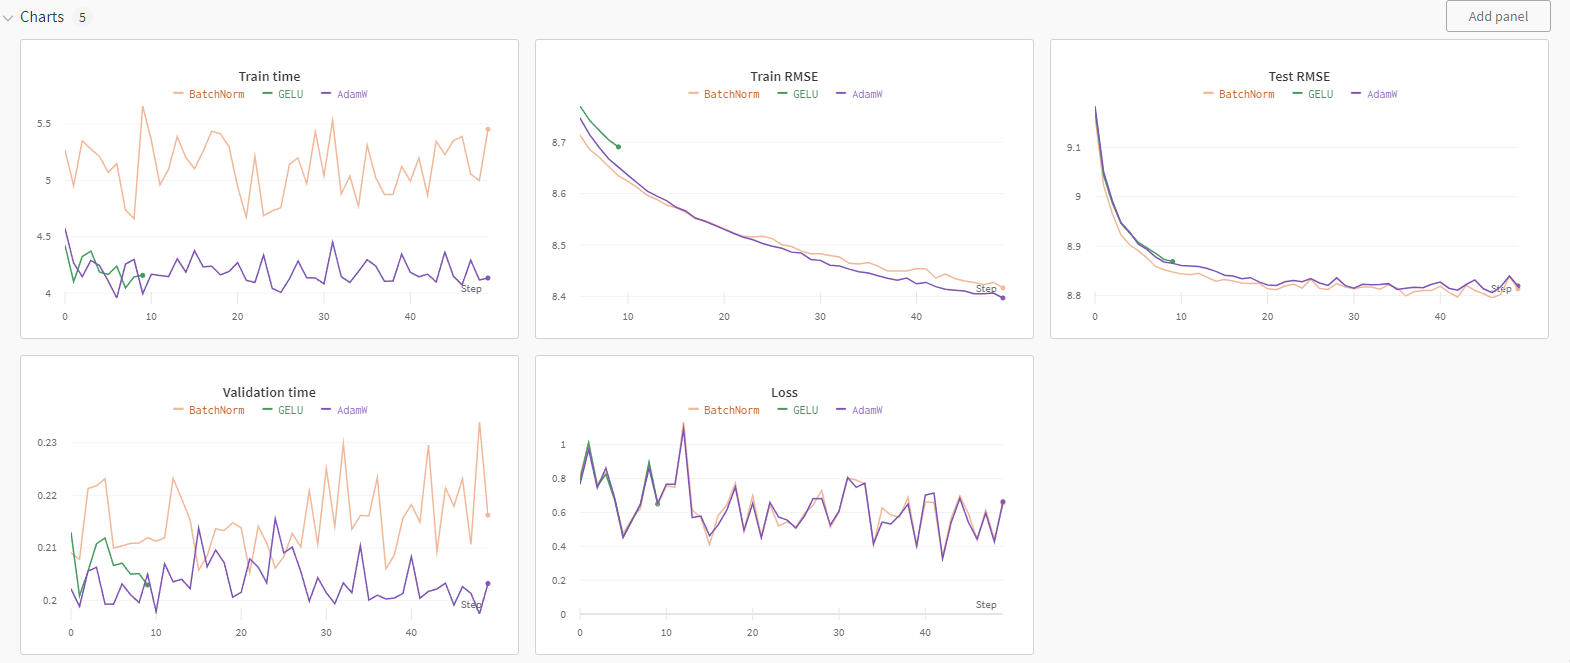

Действительно, стало лучше. Но время обучения заметно увеличилось.

### Увеличение количества скрытых нейронов

Достаточное качество не было достигнуто. Попробуем поменять количество нейронов в скрытых слоях - это единственное, что мы еще не делали.

In [58]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Linear(60, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "90 + 60 neurons", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [04:30<00:00,  5.41s/it]


Loss,▃▃▂▇▂▂▇█▃▅▂▁▁▄▃▂▄▂▃▂▂▆▂▅▃▅▆▃▅▄▁▂▂▂▃▂▃▂▁▂
Test RMSE,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▂▂▂▂▂▂
Train RMSE,█▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
Train time,▇▇▅▆▃▂▂▄▅█▇▇▆▄▇█▆▄▆▅▂▄▄▇▆▃▅▅▃▂▆▂▃▃▂▃▁▃▅▁
Validation time,█▅▅▃▂▂▁▃▄▆▄▇▄▃▃▄▄▅▂▃▄▅▄▅▅▄▂▂▂▂▄▂▁▂▃▃▂▃▃▃
Loss,0.50592
Test RMSE,8.84759
Train RMSE,8.28421
Train time,4.72594
Validation time,0.22196


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697140322995]

[1697140322995]: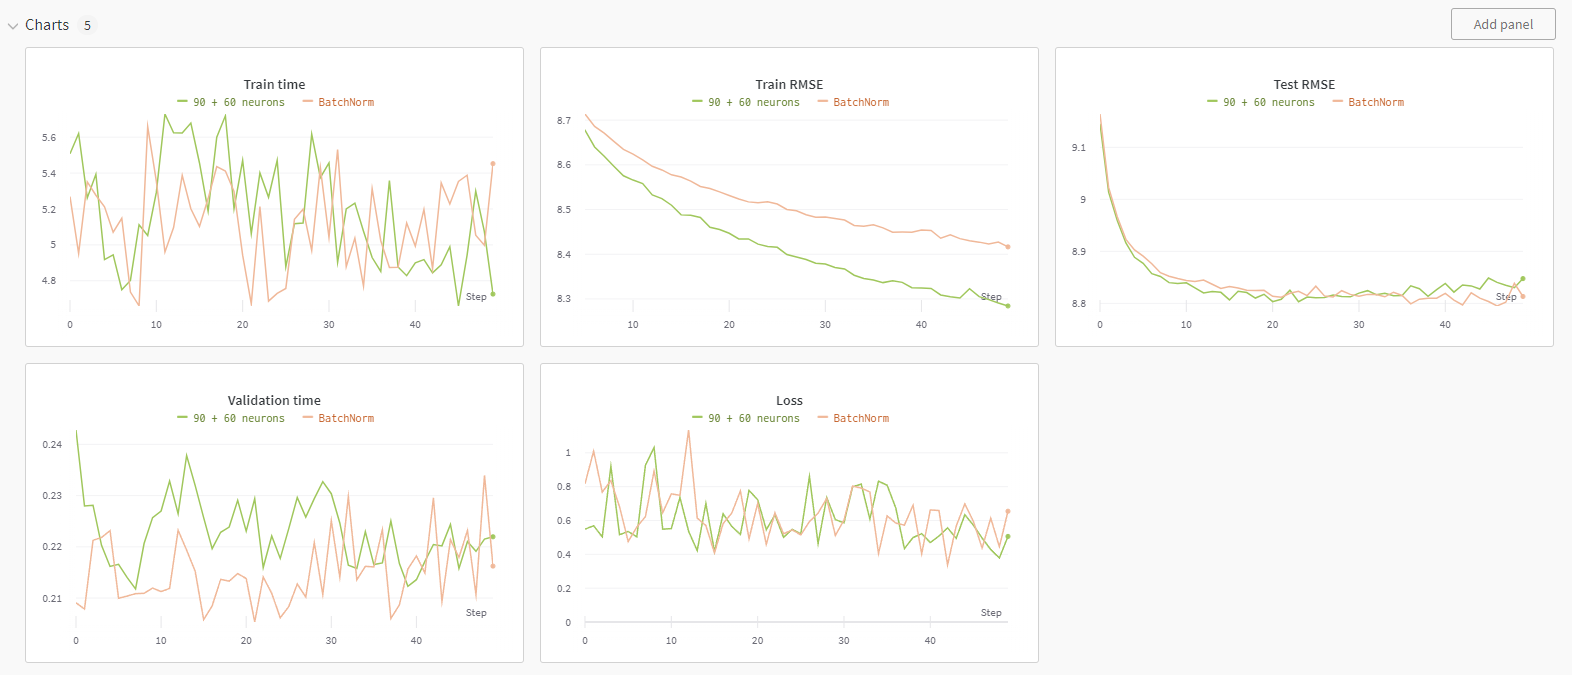

Явно наблюдается переобучение. Попробуем воспользоваться Dropout для борьбы с ним.

### Dropout

In [59]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "90 + 60, Dropout", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [04:25<00:00,  5.30s/it]


Loss,▃▄▂▆▃▂▆█▃▅▃▂▁▄▃▃▄▂▃▂▂▅▂▅▃▆▅▃▆▃▁▂▂▃▂▂▄▃▂▂
Test RMSE,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train time,▇▆▅▅▅▄▇▅▅▆▄▄▃▃▅▅▃▅▃█▅▆▅▆▅▇▇▆▁▃▅▅▇█▆▆▆▃▄▄
Validation time,▃▂▂▂▂▂▅▃▃▃▁▃▁▁▃▃▂▁▁▂█▂▂▂▃▂▂▁▂▂▁▁▁▂▃▂▃▂▂▂
Loss,0.5027
Test RMSE,8.77557
Train RMSE,8.44782
Train time,4.88624
Validation time,0.2185


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697140374986]

[1697140374986]: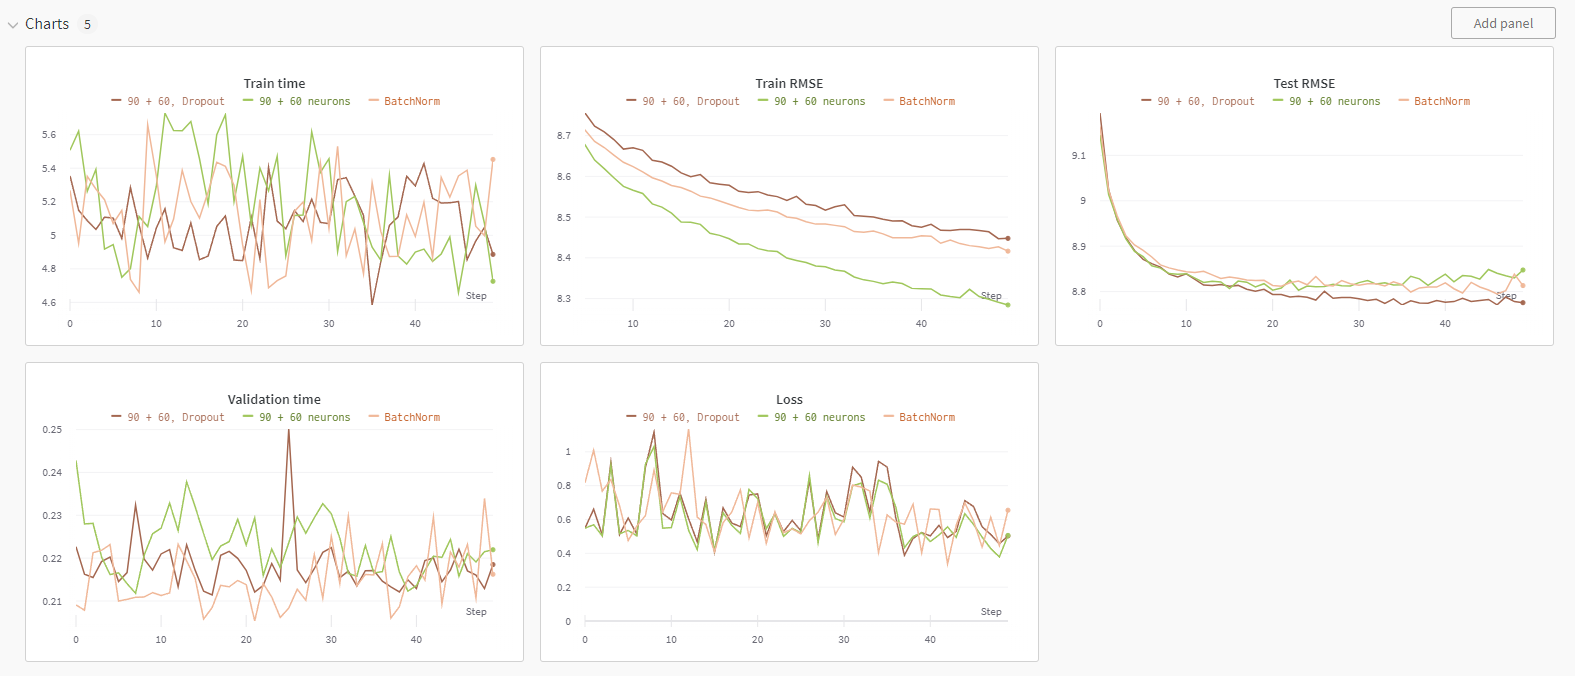

Качество заметно увеличилось и переобучение больше не наблюдается. Тем не менее необходимого RMSE на тестовой выборке модель не достигла. Попробуем добавить ещё один слой: как было получено ранее, это повышает качество, но ведёт к переобучению, поэтому также воспользуемся Dropout.

In [60]:
set_random_seed(42)
model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(30, 1)
).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
try_model(name = "90 + 60 + 30, Dropout", model = model, optimizer = optimizer, batch_size = 256)

100%|██████████| 50/50 [05:14<00:00,  6.29s/it]


Loss,▂▃▂▅▂▃▂▃▅▅▃▅▂▂▂▄▃▃█▄▃▂▃▄▄▂▁▇▃▅▃▂▆▂▂▅▄▃▃▅
Test RMSE,█▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
Train time,▅▂▁▄▅▃▅▅▂▄▄▃▇▂▄▆▃▅▃▄▄▅▆▅▆▆▃▆▄▂▃▆▅▄▁█▃▆▄▂
Validation time,▂▂▁▄▃▂▂█▁▃▃▂▂▃▆▄▄▃▃▂▁▂▂▃▂▄▁▂▂▁▁▃▄▃▂▇▄▃▃▂
Loss,0.86585
Test RMSE,8.74196
Train RMSE,8.37453
Train time,5.80993
Validation time,0.22332


,,Name,Final test RMSE,Final train RMSE,Best test RMSE,Best train RMSE,Average train time,Average validation time
0,,First model,8.908939,8.649161,8.881378,8.638528,4.303136,0.263859
1,,First model - 2,8.934217,8.728415,8.932058,8.728415,4.440032,0.262297
2,,45 neurons,8.934217,8.728415,8.932058,8.728415,4.012477,0.294769
3,,60 + 30 neurons,8.819317,8.396860,8.805555,8.396860,4.058485,0.355231
4,,65 + 40 + 20 neurons,8.872773,8.315839,8.813682,8.315839,4.431651,0.341707
5,,72 + 54 + 36 + 18 neurons,8.882663,8.213745,8.811204,8.213745,4.871843,0.332942
6,,32 Batch,8.821418,8.301617,8.793747,8.295025,19.717228,0.215120
7,,32 Batch - smaller lr,8.809176,8.480552,8.808007,8.480552,19.563758,0.209987
8,,64 Batch,8.815725,8.429944,8.809700,8.429944,10.374580,0.205005
9,,128 Batch,8.818400,8.444217,8.811111,8.444217,6.487521,0.209796


![Alternative Text][1697140551802]

[1697140551802]: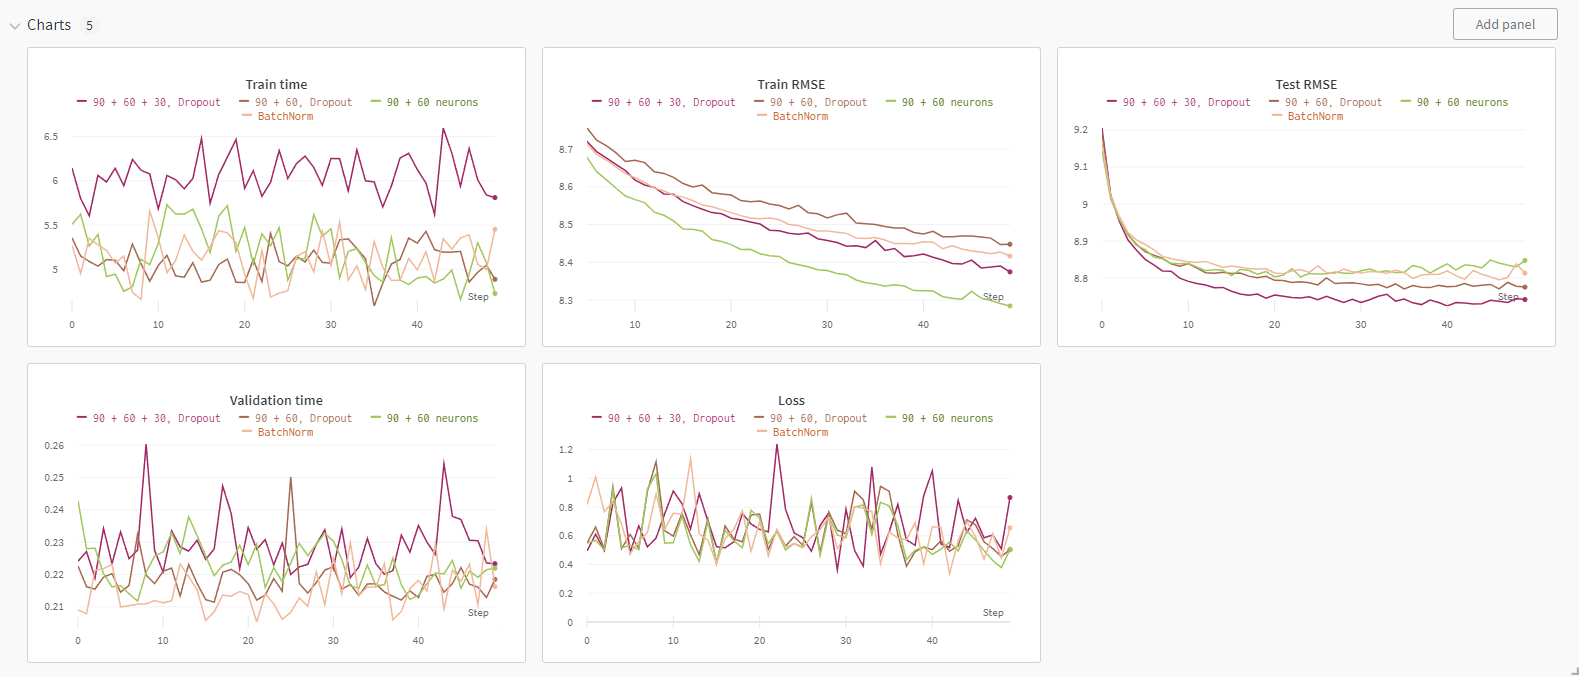

### Результат
Наилучшее качество было достигнуто на 41 эпохе. Воспользуемся этим значением.

In [61]:
set_random_seed(42)

model = torch.nn.Sequential(
    torch.nn.Linear(90, 90), torch.nn.BatchNorm1d(90),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(90, 60), torch.nn.BatchNorm1d(60),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(60, 30), torch.nn.BatchNorm1d(30),
    torch.nn.GELU(), torch.nn.Dropout(0.2), torch.nn.Linear(30, 1)
).to(device)

model = Model(
    model = model,
    device = device,
    batch_size = 256,
    name = "Final model",
    metrics = calc_metrics,
    optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-4)
).fit(X_train, y_train, 41)

calc_metrics(model)

100%|██████████| 41/41 [04:12<00:00,  6.17s/it]


Loss,▂▃▂▅▆▂▃▂▃▄▅▅▃▅▄▂▂▃▄▄▃▃█▄▃▃▂▃▄▁▄▂▁▇▂▃▅▃▂▇
Test RMSE,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train RMSE,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Train time,▅▅▅▇▇▄▄█▄▃▃▅▃▃▄▃▃▃▂▃▄▂▂▄▃▁▂▄▂▃▂▂▄▃▂▃▃▂▆▅
Validation time,▇▂▅▁▇▃▄▂▆▂▃▃▆▂▃▂▂▃▄█▄▃▄▁▁▃▂▄▂▂▃▂▂▄▃▄▂▂▄▅
Loss,1.052
Test RMSE,8.72453
Train RMSE,8.42172
Train time,6.10657
Validation time,0.22919


{'Train RMSE': 8.42171842421082, 'Test RMSE': 8.724532315695882}

![Alternative Text][1697140807428]

[1697140807428]: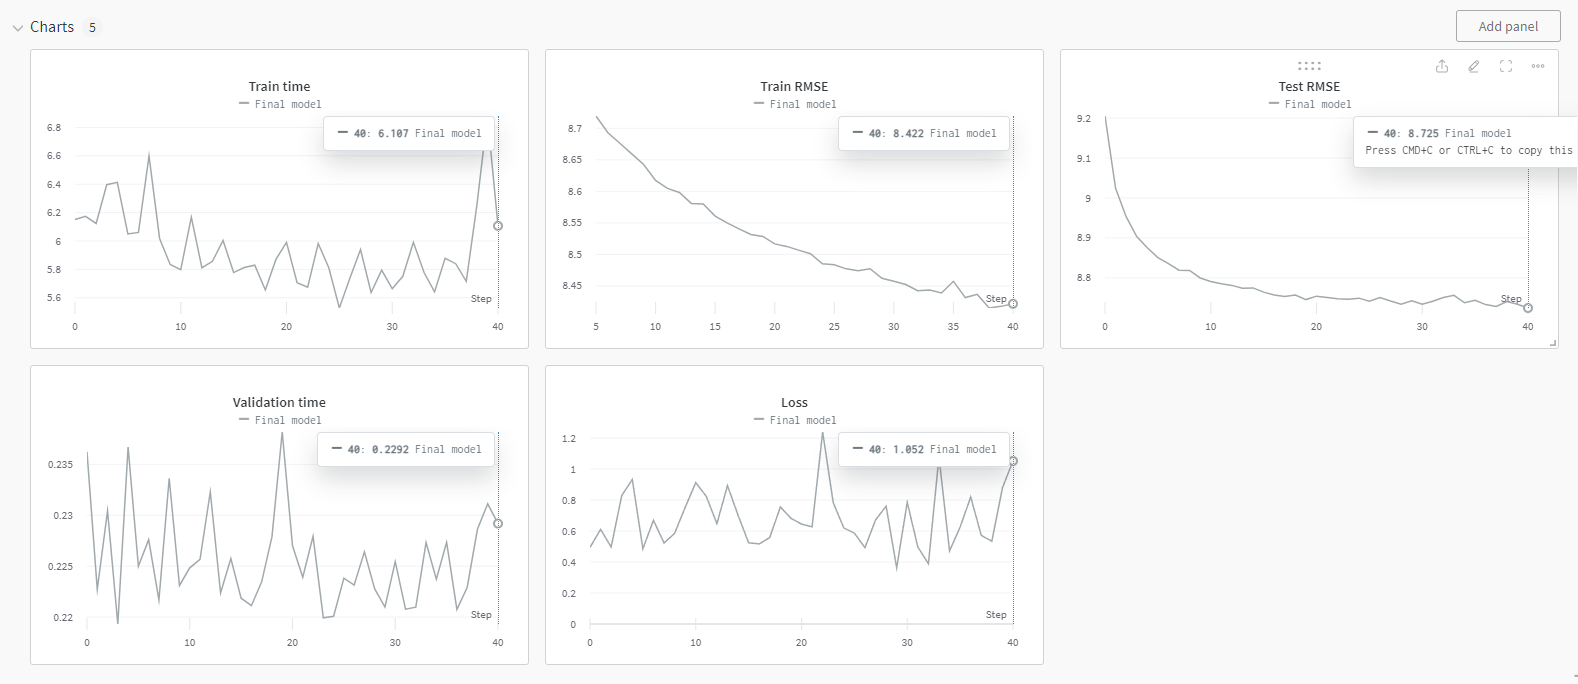

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

В ходе экспериментов было выявлено следующее:
- Увеличение количества полносвязных слоёв и нейронов в них не обязательно приводит к улучшению модели. Напротив, слишком большое количество скрытых нейронов ведёт к переобучению и, как следствие, понижению качества. На представленных данных переобучение проявилось уже при использовании трёх полносвязных слоёв. Для достижения наилучшего качество пришлось с ним бороться.
- При изменении размера пакета нужно пропорциронально корректировать скорость обучения (длину шага).
- Чем больше размер пакета, тем быстрее обучается модель. Тем не менее слишком большой размер пакета приводит к переобучению. 256 показалось мне наиболее оптимальным значением этого гиперпараметра.
- Момент и регуляризация, ожидаемо, не оказывают видимого влияния на качество модели при отсутствии переобучения. Тем не менее адаптивная скорость обучения, реализованная алгоритмом AdamW, позволяет значительно повысить качество.
- Эксперименты с нелинейностью не дали неожиданных результатов: наиболее часто используемые функции (ReLU, GELU, LeakyReLU, PReLU и др.) показывают примерно одинаковое качество, а сигмоида и другие функции, обладающие рядом теоретических проблем, показывают себя немного хуже.
- Нормализация выходов скрытых слоёв позволяет добиться заметного повышения качества, но и значительно повышает время обучения модели.
- Dropout - очень эффективный метод борьбы с переобучением. Применение этого алгоритма даже без подбора гиперпараметра (вероятности зануления элементов входного тензора) позволило избавиться от переобучения и значительно повысить качество модели.

С учётом всех проведённых экспериментов была построена модель, состоящая из трёх скрытых слоёв, содержащих по 90, 60 и 30 нейронов соответственно, между которыми используется нормализация, нелинейность GELU и Dropout. С использованием алгоритма оптимизации AdamW и размера пакета 256 за 41 итерацию обучения удалось достичь RMSE на тестовой выборке 8.725